#### Importing modules

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mode
import chiCa
from spks import *

%matplotlib widget

#### Loading sync data

In [3]:
from spks.sync import load_ni_sync_data,interp1d
sessionpath = Path('/home/data/GRB006/20240429_174359/')
sync_port = 0 # this is where the SMA of the probe is connected

(nionsets,nioffsets),(nisync,nimeta),(apsyncdata) = load_ni_sync_data(sessionpath=sessionpath)
aponsets = apsyncdata[0]['file0_sync_onsets'][6] # this should be the same for you, its where the sync is on the probe

corrected_onsets = {} # This is a dictionary with the digital events that were connected to the breakout box.
for k in nionsets.keys():
    corrected_onsets[k] = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(nionsets[k]).astype('uint64')

# if you need analog channels those are in "nisync"
nitime = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(np.arange(len(nisync)))

# everything is in samples, use this sampling rate
srate = apsyncdata[0]['sampling_rate']  

frame_rate = mode(1/(np.diff(corrected_onsets[1])/srate)) #corrected_onsets[1] are the frame samples, [2] are the trial start samples
trial_start_times = corrected_onsets[2][:-1]/srate

analog_signal = nisync[:, 0] # analog stim signal

In [4]:
behavior_data = chiCa.load_trialdata('/home/data/GRB006/20240429_174359/chipmunk/GRB006_20240429_174359_chipmunk_DemonstratorAudiTask.mat')

stim_onsets = []
for trial_index, timestamps in enumerate(chiCa.get_experienced_stimulus_events(behavior_data)): #behavior_data['stimulus_event_timestamps'])
    if True: #behavior_data.outcome_record[trial_index] != -1 and behavior_data.outcome_record[trial_index] != 2: 
        stim_timestamps = [trial_start_times[trial_index] + timestamp for timestamp in timestamps]
        stim_onsets.append(stim_timestamps)
    else: #discarding stimuli that occurred during early withdrawals and no choice trials
        stim_onsets.append(None)

first_stim_onsets = np.zeros(len(stim_onsets))
sk = np.zeros((len(stim_onsets)), dtype=object)
for trial, timestamps in enumerate(stim_onsets):
    if timestamps is None:
        first_stim_onsets[trial] = np.nan
        sk[trial] = np.nan
    else:
        first_stim_onsets[trial] = timestamps[0]
        sk[trial] = timestamps

sk_stacked = np.hstack(sk)
stim_kernel = sk_stacked[~np.isnan(sk_stacked)]

#check every thing has the correct size. length here should equal number of trials
assert len(first_stim_onsets) == len(stim_onsets) == len(sk)

/opt/conda/envs/spks-gabriel/lib/python3.12/site-packages/chiCa/chipmunk_analysis_tools.py:321: UserWarning: Found multisensory trials, assumed synchronous condition
  warnings.warn('Found multisensory trials, assumed synchronous condition')


In [247]:
#for figuring out the time window for a given range of trials to plot belos
corrected_onsets[2][157:159]/srate

array([868.0196    , 869.90106667])

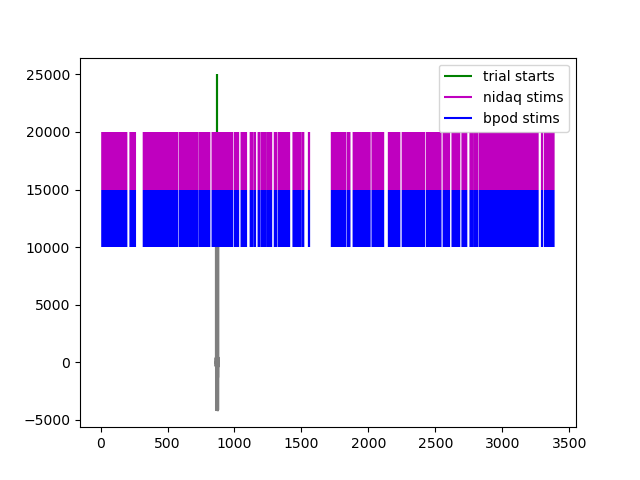

In [242]:
# analog_signal = nisync[:, 0]
t = nitime/srate
# t_limit = 300
# idx = t<t_limit #first # of seconds of the session, for indexing the analog signal
idx = (t > 860) & (t < 880)
ti = np.where(corrected_onsets[2]/srate<t_limit) #trial index
threshold = 15000

ii = np.where(np.diff(analog_signal>threshold)==1)[0] #for indexing the detected stim events above threshold in the entire session
# ii = np.where(np.diff(analog_signal[idx]>threshold)==1)[0] #same thing but for a subsample of the session
stim_events_nidaq = t[ii[np.diff(np.hstack([0,ii]))>0.04*srate]]

plt.figure()
plt.plot(t[idx],analog_signal[idx],'k', alpha=0.5) #raw analog signal
plt.vlines(corrected_onsets[2][157:159]/srate,20000,25000,'g', label='trial starts') #trial starts
plt.vlines(stim_events_nidaq,15000,20000,'m', label='nidaq stims') #stim events
plt.vlines(np.hstack(stim_onsets), 10000, 15000, 'b', label='bpod stims') #bpod stim events
plt.legend()
# print(f'bpod stimulus events: {len(np.hstack(stim_onsets))}\nnidaq stimulus events: {len(stim_events_nidaq)}')

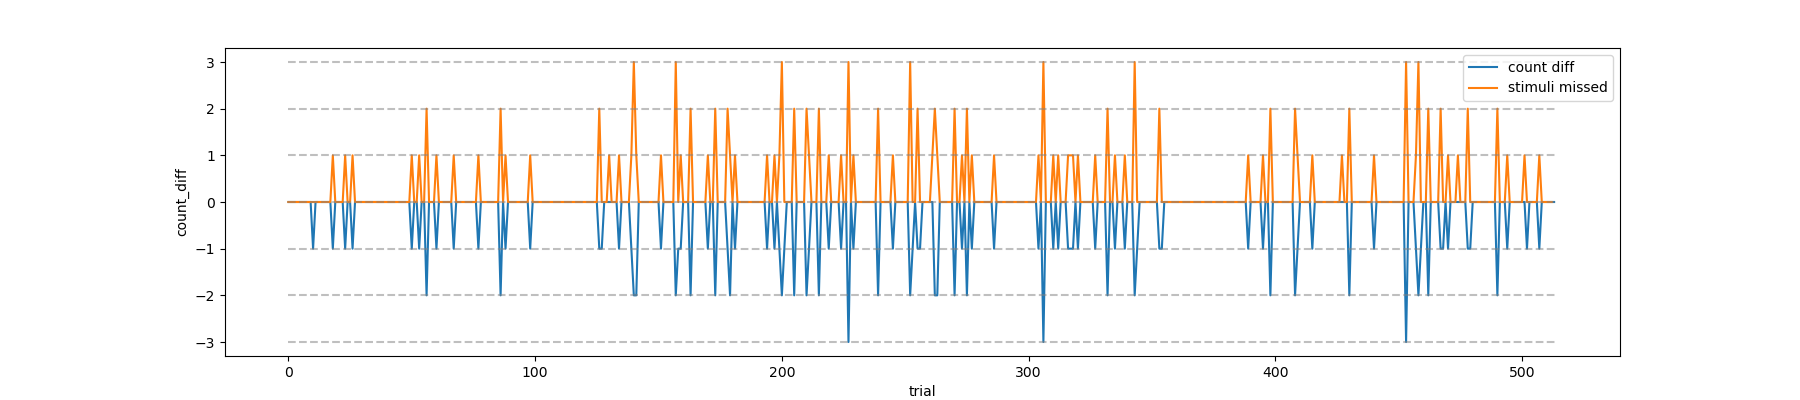

In [239]:
# s = behavior_data.iloc[157].stimulus_event_timestamps
# r = behavior_data.iloc[157].DemonWaitForResponse[1]
# s < r

stimuli_missed = []
for trial in range(len(behavior_data)):
    s = behavior_data.iloc[trial].stimulus_event_timestamps
    r = behavior_data.iloc[trial].DemonWaitForResponse[1]
    stimuli_missed.append(np.sum(s > r))

nidaq_events_per_trial = []
bpod_events_per_trial = []
for trial, st_ts in enumerate(corrected_onsets[2]/srate):
    if trial != len(corrected_onsets[2])-1:
        nidaq_events_per_trial.append(len(np.where((corrected_onsets[2][trial]/srate < stim_events_nidaq) & (stim_events_nidaq < corrected_onsets[2][trial+1]/srate))[0]))
        bpod_events_per_trial.append(len(np.where((corrected_onsets[2][trial]/srate < np.hstack(stim_onsets)) & (np.hstack(stim_onsets) < corrected_onsets[2][trial+1]/srate))[0]))
    else: 
        nidaq_events_per_trial.append(len(np.where((corrected_onsets[2][trial]/srate < stim_events_nidaq))[0]))
        bpod_events_per_trial.append(len(np.where((corrected_onsets[2][trial]/srate < np.hstack(stim_onsets)))[0]))

# nidaq_events_per_trial[157], bpod_events_per_trial[157]

count_diff = np.array(nidaq_events_per_trial) - np.array(bpod_events_per_trial)


plt.figure(figsize=(18, 4))
# plt.plot(nidaq_events_per_trial)
# plt.plot(bpod_events_per_trial)
plt.plot(count_diff, label='count diff')
plt.plot(stimuli_missed, label='stimuli missed')
plt.ylabel('count_diff')
plt.xlabel('trial')
plt.hlines(y = [3,2,1,0,-1,-2,-3], xmin=0, xmax=len(count_diff), colors='grey', alpha = 0.5, linestyles='dashed')
plt.legend()

# plt.scatter(response_time, count_diff, color='r', alpha = 0.5)
# plt.ylabel('count_diff')
# plt.xlabel('response_time')
# plt.vlines(0.5, ymin=-3, ymax=0, color='grey', linestyles='dashed')

##### Explanation for mismatch of stim events between nidaq and bpod!
The reason for this is that bpod loads all the stimuli it's going to play. However, the mouse can respond before the stimuli finish playing. This leads to a mismatch between the stimuli that are *meant* to be played and the ones that actually are. Additionally, there are cases that since the ITI is so small, the next trial starts before the last stimuli can be played given that the response can be so fast and the response triggers the end of the current trial. These two reasons combine to produce the mismatch~

##### Load clusters object for current session to obtain cluster IDs

Also filtering units using Melin et al. 2024 preprint criteria

In [9]:
# binary_path = Path('/home/data/GRB006/20240429_174359/ephys_g0/ephys_g0_imec0/ephys_g0_t0.imec0.ap.bin')
# fast_binary_path = Path('/scratch/GRB/temp_bin/ephys_g0_t0.imec0.ap.bin')
kilosort_path = Path('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/')

clu = Clusters(folder = kilosort_path, get_waveforms=False, get_metrics=True, load_template_features=True)

# ---------- this gets the row indices ---------- #
single_unit_idx = np.where((np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) > 50)
            & (clu.cluster_info.amplitude_cutoff < 0.1) 
            & (clu.cluster_info.isi_contamination < 0.1)
            & (clu.cluster_info.presence_ratio >= 0.6)
            & (clu.cluster_info.spike_duration > 0.1))[0]

# ---------- and this get the cluster_id values ---------- #
mask = ((np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) > 50)
            & (clu.cluster_info.amplitude_cutoff < 0.1) 
            & (clu.cluster_info.isi_contamination < 0.1)
            & (clu.cluster_info.presence_ratio >= 0.6)
            & (clu.cluster_info.spike_duration > 0.1))


single_unit_ids = clu.cluster_info[mask].cluster_id.values

#### Population activity heatmap across trials
Code taken from: https://github.com/jcouto/cshl_spks/blob/main/tutorials/tutorial_plot_psths.ipynb

In [ ]:
# sc = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_clusters.npy') #KS clusters
# ss = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_times.npy') #KS spikes (in samples)

# st = ss/srate #conversion from spike samples to spike times

# selection = np.isin(sc,single_unit_ids)

# binsize = 0.01 # 10ms binsize
# edges = np.arange(0,np.max(st[selection]),binsize)

# pop_rate,_ = np.histogram(st[selection],edges)
# pop_rate = pop_rate/binsize
# pop_rate_time = edges[:-1]+np.diff(edges[:2])/2

# psth = []
# tpre = 0.1
# tpost = 0.5

# for onset in first_stim_onsets:
#     if ~np.isnan(onset):
#        psth.append(pop_rate[(pop_rate_time>= onset -tpre) & (pop_rate_time< onset +tpost)])
# psth = np.stack(psth)
# fig2 = plt.figure(figsize=(4,4))
# plt.imshow(psth,aspect='auto',extent=[-tpre,tpost,0,len(psth)],cmap = 'RdBu_r',clim = [0,2500])
# plt.vlines(x = 0, ymin = plt.ylim()[0], ymax = plt.ylim()[1], linestyles = 'dashed', color = 'k')
# plt.colorbar(label='Population rate (Hz)')
# plt.xlabel('time from first stim event')
# plt.ylabel('Number of trials')
# fig2.tight_layout()

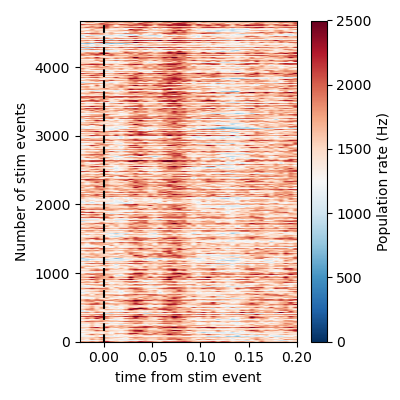

In [12]:
sc = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_clusters.npy') #KS clusters
ss = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_times.npy') #KS spikes (in samples)

st = ss/srate #conversion from spike samples to spike times

selection = np.isin(sc,single_unit_ids)

binsize = 0.005 # 10ms binsize
edges = np.arange(0,np.max(st[selection]),binsize)

pop_rate,_ = np.histogram(st[selection],edges)
pop_rate = pop_rate/binsize
pop_rate_time = edges[:-1]+np.diff(edges[:2])/2

psth = []
tpre = 0.025
tpost = 0.2

for onset in stim_events_nidaq:#stim_events_nidaq:
    if ~np.isnan(onset):
       psth.append(pop_rate[(pop_rate_time>= onset -tpre) & (pop_rate_time< onset +tpost)])
psth = np.stack(psth)
kernel_fig = plt.figure(figsize=(4,4))
plt.imshow(psth,aspect='auto',extent=[-tpre,tpost,0,len(psth)],cmap = 'RdBu_r',clim = [0,2500])
plt.vlines(x = 0, ymin = plt.ylim()[0], ymax = plt.ylim()[1], linestyles = 'dashed', color = 'k')
plt.colorbar(label='Population rate (Hz)')
plt.xlabel('time from stim event')
plt.ylabel('Number of stim events')
kernel_fig.tight_layout()

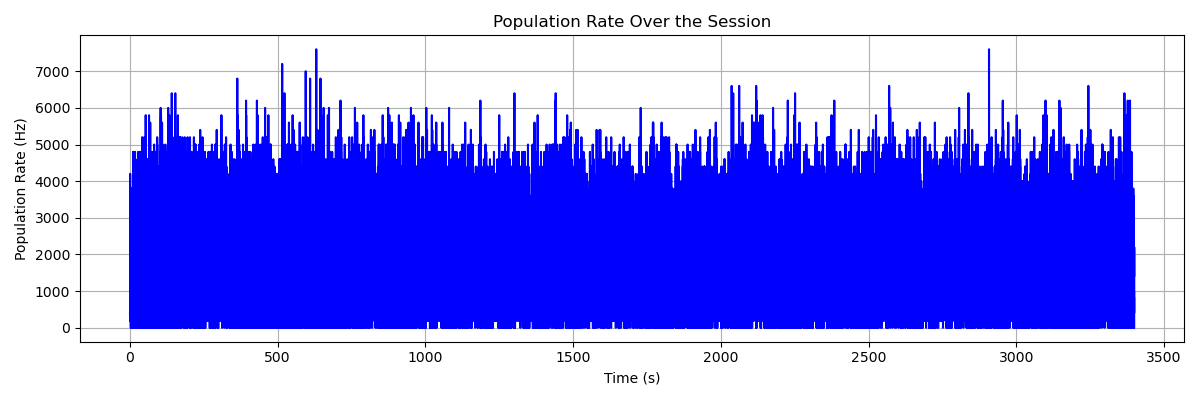

In [176]:
plt.figure(figsize=(12, 4))
plt.plot(pop_rate_time, pop_rate, color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Population Rate (Hz)')
plt.title('Population Rate Over the Session')
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
mean_rate = np.mean(pop_rate)
pop_rate_minus_mean = pop_rate - mean_rate

from scipy.ndimage import gaussian_filter1d

FWHM_constant = 2.355
smooth_window = 100
# Smooth using a Gaussian filter with a standard deviation corresponding to 100 seconds
sigma = smooth_window / binsize / FWHM_constant  # Sigma value for Gaussian filter
smoothed_data = gaussian_filter1d(pop_rate_minus_mean, sigma=sigma)

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(pop_rate_time, smoothed_data, color='blue', lw=2, label='Gaussian Smoothed Population Rate - Mean Rate')

# Add a horizontal line at y=0 for reference
plt.axhline(0, color='black', linestyle='--', lw=1, label='Mean Rate')

# Add labels and title
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Population Rate - Mean Rate (Hz)', fontsize=14)
plt.title('Gaussian Smoothed Population Rate Minus Mean Rate Over the Session', fontsize=16)
plt.legend()
plt.grid(True, which='both', linestyle='--', color='gray', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()



NameError: name 'np' is not defined

ValueError: x and y must have same first dimension, but have shapes (31,) and (38,)

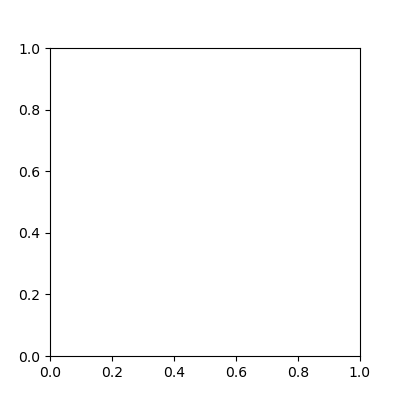

In [157]:
from useful_functions import separate_axes

def plot_population_psth(event_times, spike_times, pre=0.5, post=1, binw=0.01, use_kernel=False, kernel_width=2, ax=None):
    """
    Plots the Peri-Stimulus Time Histogram (PSTH) with SEM shading on a specific axis.
    
    Parameters:
    - event_times: array-like, times of the stimulus events.
    - spike_times: array-like, times of the spikes.
    - pre: float, time window before the stimulus event.
    - post: float, time window after the stimulus event.
    - binw: float, bin width for the histogram.
    - use_kernel: bool, whether to use Gaussian kernel smoothing.
    - kernel_width: float, width of the Gaussian kernel for smoothing.
    - ax: matplotlib axis object, axis to plot on.
    """
    if ax is None:
        ax = plt.gca()  # Get current axis if none is provided
    
    if use_kernel:
        psth_matrix, event_index = compute_firing_rate(
            event_times=event_times,
            spike_times=spike_times,
            pre_seconds=pre,
            post_seconds=post,
            binwidth_ms=int(binw * 1000),
            kernel=gaussian_function(kernel_width)
        )
    else:
        psth_matrix, event_index = compute_firing_rate(
            event_times=event_times,
            spike_times=spike_times,
            pre_seconds=pre,
            post_seconds=post,
            binwidth_ms=int(binw * 1000),
            kernel=None
        )
            
    trial_avg_psth = np.mean(psth_matrix, axis=0)
    trial_sem_psth = np.std(psth_matrix, axis=0) / np.sqrt(psth_matrix.shape[0])

    x_nums = np.arange(-pre, post, binw)
    if use_kernel:
        ax.plot(x_nums[:-1], trial_avg_psth, label='Average PSTH')
        ax.fill_between(x_nums[:-1], trial_avg_psth - trial_sem_psth, trial_avg_psth + trial_sem_psth, alpha=0.3, label='SEM')
    else:
        ax.plot(x_nums, trial_avg_psth, label='Average PSTH')
        ax.fill_between(x_nums, trial_avg_psth - trial_sem_psth, trial_avg_psth + trial_sem_psth, alpha=0.3, label='SEM')
    ax.vlines([0], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed', color='gray')
    ax.set_xlabel('Time from first stimulus event (s)')
    ax.set_ylabel('Firing rate (Hz)')
    # ax.set_title(f'Trial avg PSTH with SEM; iunit: {iunit}')

    # separate_axes(ax)

binsize = 0.0025
tpre = 0.025
tpost = 0.05
# pop_psth_fig, axs = plt.subplots(1,2, figsize=(12,12))
kernel_psth_fig, ax = plt.subplots(1,1, figsize=(4,4))
plot_population_psth(event_times=stim_events_nidaq, spike_times=st, pre=tpre, post=tpost, binw=binsize, use_kernel=False, kernel_width=1, ax=ax)
# plot_population_psth(event_times=stim_kernel, spike_times=st, pre=tpre, post=tpost, binw=binsize, use_kernel=True, kernel_width=1, ax=axs[1])

In [ ]:
plt.close(pop_psth_fig)
binsize = 0.01
tpre = 0.5
tpost = 1
pop_psth_fig, axs = plt.subplots(1,2, figsize=(12,6))
# kernel_psth_fig, ax = plt.subplots(1,1, figsize=(12,12))
plot_population_psth(event_times=first_stim_onsets, spike_times=st, pre=tpre, post=tpost, binw=binsize, use_kernel=False, kernel_width=1, ax=axs[0])
plot_population_psth(event_times=first_stim_onsets, spike_times=st, pre=tpre, post=tpost, binw=binsize, use_kernel=True, kernel_width=1, ax=axs[1])

Playing around in the next cell with sorting the trials per total amounts of activity

In [ ]:
# # Assuming 'psth' is already defined and sorted_indices is obtained as before
# # Sum the responses for each trial
# trial_sums = np.sum(psth, axis=1)

# # Get the indices that would sort the trial sums in descending order
# sorted_indices = np.argsort(trial_sums)[::-1]

# # Apply the sorted indices to psth to sort it
# sorted_psth = psth[sorted_indices]

# # Create a mapping of sorted indices to original trial numbers
# trial_numbers = np.arange(len(psth)) + 1  # Assuming trial numbering starts from 1
# sorted_trial_numbers = trial_numbers[sorted_indices]

# tpre = 0
# tpost = 0.5

# # Plotting the sorted heatmap with trial identity maintained on the y-axis
# fig3 = plt.figure(figsize=(4, 4))
# ax = fig3.gca()
# heatmap = ax.imshow(sorted_psth, aspect='auto', extent=[-tpre, tpost, 0, len(sorted_psth)], cmap='RdBu_r', clim=[0, 2500])

# # Adjust the y-ticks to ensure they are spaced out appropriately
# # This might involve setting fewer y-ticks if there are many trials
# num_trials = len(sorted_trial_numbers)
# tick_spacing = max(1, num_trials // 10)  # Adjust the 10 to control tick density
# selected_ticks = np.arange(0, num_trials, tick_spacing)

# # Apply the selected ticks and their corresponding labels
# ax.set_yticks(selected_ticks)
# ax.set_yticklabels(sorted_trial_numbers[selected_ticks], fontsize=8)  # Adjust fontsize as needed

# plt.colorbar(heatmap, label='Population rate (Hz)')
# plt.xlabel('time from first stim event', fontsize=10)  # Adjust fontsize as needed
# plt.ylabel('Trial number', fontsize=10)  # Adjust fontsize as needed
# # fig3.tight_layout()

In [ ]:
#interesting units to plot
#excitation: 67, 28, 29, 32, 105, 136, 151, 154, 209, 216
#inhibition: 4, 82, 84, 67, 82, 99, 106, 162, 166, 167

In [ ]:
from useful_functions import individual_raster_viewer

clus = sc[selection]
# separate the spikes from each unit
spike_timestamps = [st[selection][clus == uclu] for uclu in np.unique(clus)]

trig_ts = []
for sp in spike_timestamps:
    trig_ts.append([])
    for o in first_stim_onsets:
        trig_ts[-1].append(sp[(sp>=(o-tpre)) & (sp<(o+tpost))] - o)
        
individual_raster_viewer(trig_ts)

In [ ]:
from spks.viz import plot_event_aligned_raster

fig3, ax = plt.subplots(1,1)
plot_event_aligned_raster(event_times=first_stim_onsets, spike_times=spike_timestamps[154], ax=ax)
fig3.tight_layout()

I prefer to get event aligned spks with the function below (get triggered spks)

from spks.event_aligned import *

tspks = get_triggered_spikes(spike_timestamps,first_stim_onsets,tpre = 1,tpost = 1)

fig4 = plt.figure()
plot_raster(spks=tspks[154])

In [ ]:
# from useful_functions import separate_axes

# pre = 0.5
# post = 1
# binw = 0.01

# psth_matrix, event_index = compute_firing_rate(event_times=first_stim_onsets, spike_times=timestamps[154], pre_seconds=pre, post_seconds=post, binwidth_ms=int(binw*1000), kernel=gaussian_function(2))
# trial_avg_psth = np.mean(psth_matrix, axis=0)
# trial_sem_psth = np.std(psth_matrix, axis=0) / np.sqrt(psth_matrix.shape[0])

# fig5 = plt.figure()
# x_nums = np.arange(-pre, post, binw)
# plt.plot(x_nums[:-1], trial_avg_psth)
# plt.fill_between(x_nums[:-1], trial_avg_psth - trial_sem_psth, trial_avg_psth + trial_sem_psth, alpha=0.3)
# plt.vlines([0], ymin = plt.ylim()[0], ymax = plt.ylim()[1], linestyles='dashed', color='gray')
# plt.ylabel('Firing rate (Hz)')
# plt.xlabel('Time from first stimulus event (s)')

# ax = plt.gca()
# separate_axes(ax)

In [ ]:
from useful_functions import plot_psth

fig5 = plt.figure()
plot_psth(iunit = 154, event_times = first_stim_onsets, spike_times = spike_timestamps, pre = 0.5, post = 1)
fig5.tight_layout()

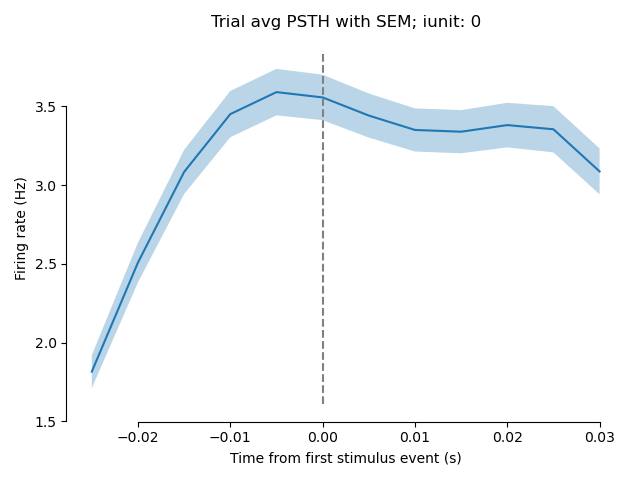

In [125]:
from useful_functions import individual_psth_viewer

clus = sc[selection]
# separate the spikes from each unit
spike_timestamps = [st[selection][clus == uclu] for uclu in np.unique(clus)]

plt.figure()
individual_psth_viewer(event_times = stim_events_nidaq, spike_times = spike_timestamps, pre = 0.025, post = 0.04, binw = 0.005)
plt.tight_layout()

In [ ]:
first_stim_onsets